<a href="https://colab.research.google.com/github/Kusuru-Meghana/Alz-Detect---Machine-Learning-on-Blood-Transcriptomics/blob/main/alz_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Alzheimer’s Blood Transcriptomic ML Pipeline


I built a small, explainable ML model that reads a person’s blood gene-expression and predicts Alzheimer’s (AD) vs control (CTL). It also tells you which genes pushed the call. I started wide, learned with logistic/XGBoost, and then shrank everything to a practical 20-gene panel. Finally, I tested it on a separate study to see how well it holds up in the real world.

##Why I did it
AD is often detected late. If a blood signature can flag risk and point to pathways, that helps both screening and downstream drug-repurposing (my follow-up project uses the up/down gene signature).



##Data

- Training -  GSE63060 (Illumina HT-12 v3), blood expression.

   I kept AD vs CTL only --> 249 people (145 AD / 104 CTL), 4,261 probes after cleaning.

- Independent test - GSE63061, 273 people (139 AD / 134 CTL).

- Labels came from each study’s Series Matrix. I aligned sample IDs automatically and verified that all 20 signature probes exist in the external set.

##pipeline
1. Load & align labels - drop MCI

2. Keep top 2,000 variable probes - quick PCA check

3. Stratified 70/30 split

4. Train models (LogReg, XGBoost)

5. Explain with SHAP - map probes - genes

6. Select top-20 with L1-LogReg - retrain clean logistic

7. 5-fold CV with in-fold selection - threshold tune

8. Package artifact - external validation + shift check

##Deliverables

- Polished figures: PCA, ROC, PR, SHAP beeswarm/bar, heatmap of top genes.

- CSVs: train/test splits, predictions, top50_features_shap.csv.

##What I learned
Blood transcriptomes do carry an AD signal. A small, interpretable panel is feasible. Cross-study performance drops without harmonization, so I diagnosed batch effects (many probes shifted ~9–15 SD) and outlined fixes (quantile normalization/ComBat + threshold calibration).
I built an end-to-end, explainable ML pipeline that reads a person’s blood gene-expression profile and predicts Alzheimer’s (AD) vs Control (CTL).

It discovers which genes matter, reduces the signal to a practical 20-gene panel, packages the model for reuse, and then evaluates it on a totally separate study.




In [ ]:

!pip -q install xgboost shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


##Step 1 - Load the expression matrix

In [ ]:
import pandas as pd, numpy as np, re

# Load normalized expression
expr = pd.read_csv("GSE63060_normalized.txt", sep="\t", index_col=0, low_memory=False)     # use the first column as the row index (that first column contains the gene/probe IDs like ILMN_12345
print("Raw expr shape (features x columns):", expr.shape)
print("First 10 column headers:", list(expr.columns[:10]))



Raw expr shape (features x columns): (2929, 330)
First 10 column headers: ['4856076042_C', '4856076042_L', '4856050003_A', '4856050003_F', '4856050003_K', '4856050007_C', '4856050007_H', '4856050007_L', '4856050008_A', '4856050008_C']


##Step 2 - Parse Series Matrix & auto-match columns

In [ ]:
series_path = "GSE63060_series_matrix.txt"

geo = []       # Sample_geo_accession (GSM IDs)
titles = []    # Sample_title (often codes like 4856050008_I)
status_vals = []  # Sample_characteristics_ch1 with "status - AD/CTL/MCI"

with open(series_path, "r") as f:
    for line in f:
        if line.startswith("!Sample_geo_accession"):
            geo = line.strip().split("\t")[1:]
        if line.startswith("!Sample_title"):
            titles = [s.replace('"','').strip() for s in line.strip().split("\t")[1:]]
        if line.startswith("!Sample_characteristics_ch1") and "status:" in line:
            toks = line.strip().split("\t")[1:]
            status_vals = [t.replace('"','').split(":",1)[1].strip().upper() for t in toks]

print("Counts:", len(geo), len(titles), len(status_vals))
print(pd.Series(status_vals).value_counts())


Counts: 329 329 329
AD     145
CTL    104
MCI     80
Name: count, dtype: int64


In [ ]:
# Helper to "normalize" headers (strip quotes/spaces and extract GSM if present)
def norm_gsm(s):
    s = str(s).strip().replace('"','')
    m = re.search(r'(GSM\d+)', s)
    return m.group(1) if m else s

expr_cols = [str(c).strip().replace('"','') for c in expr.columns]
geo_norm  = [norm_gsm(s) for s in geo]
titles_norm = [str(s).strip().replace('"','') for s in titles]

# Compute overlaps with both possibilities
overlap_geo    = len(set(expr_cols) & set(geo_norm))
overlap_titles = len(set(expr_cols) & set(titles_norm))
print("Overlap with GEO accessions:", overlap_geo)
print("Overlap with titles:        ", overlap_titles)

# Choose the key that matches your expr columns best
if overlap_geo >= overlap_titles and overlap_geo > 0:
    key_name   = "geo"
    key_order  = geo_norm
    key_to_status = dict(zip(geo_norm, status_vals))
elif overlap_titles > 0:
    key_name   = "title"
    key_order  = titles_norm
    key_to_status = dict(zip(titles_norm, status_vals))
else:
    raise ValueError("Could not match expression columns to GEO accessions or titles")

print("Using key:", key_name)


Overlap with GEO accessions: 0
Overlap with titles:         329
Using key: title


In [ ]:
# Keep only columns that exist in both expr and the selected key, preserving series order
common = [k for k in key_order if k in expr_cols]
expr = expr.loc[:, common]

# Build status in the exact same order
status = np.array([key_to_status[k] for k in common])

# Filter to AD vs CTL only (drop MCI)
keep_mask = (status == "AD") | (status == "CTL")
X = expr.loc[:, keep_mask].T  # samples x features
y_str = status[keep_mask]
y = (y_str == "AD").astype(int)

print("X shape:", X.shape)
print("Label balance:", dict(zip(*np.unique(y_str, return_counts=True))))
print("First 5 X rows/cols:\n", X.iloc[:2, :5])


X shape: (249, 2929)
Label balance: {np.str_('AD'): np.int64(145), np.str_('CTL'): np.int64(104)}
First 5 X rows/cols:
 ID_REF        ILMN_2055271  ILMN_2383229  ILMN_1806310  ILMN_1779670  \
4856076007_H      7.587775      7.301896      7.469983      7.473438   
4856050048_J      7.557308      7.391895      7.447469      7.575663   

ID_REF        ILMN_2321282  
4856076007_H      7.663581  
4856050048_J      7.446445  


##Step 3 - Data ingestion + label parsing + alignment (AD vs CTL only)



In [ ]:
# STEP 3 — Load expression, parse labels, align, keep AD vs CTL

import pandas as pd, numpy as np, re

# 3A. Load normalized expression (rows = probes, cols = samples)
expr = pd.read_csv("GSE63060_normalized.txt", sep="\t", index_col=0, low_memory=False)  # After this - rows = genes, columns = samples.
expr_cols = [str(c).strip().replace('"','') for c in expr.columns]          # avoids mismatches
print("Raw expr shape:", expr.shape)

# 3B. Parse sample IDs and status from the series matrix
geo, titles, status_vals = [], [], []
with open("GSE63060_series_matrix.txt", "r") as f:
    for line in f:
        if line.startswith("!Sample_geo_accession"):
            geo = line.strip().split("\t")[1:]
        if line.startswith("!Sample_title"):
            titles = [s.replace('"','').strip() for s in line.strip().split("\t")[1:]]
        if line.startswith("!Sample_characteristics_ch1") and "status:" in line:
            toks = line.strip().split("\t")[1:]
            status_vals = [t.replace('"','').split(":",1)[1].strip().upper() for t in toks]

print("Meta counts:", len(geo), len(titles), len(status_vals))
print(pd.Series(status_vals).value_counts())

# 3C. Decide which identifier matches your columns (GSM or title)
def norm_gsm(s):
    s = str(s).strip().replace('"','')
    m = re.search(r'(GSM\d+)', s)
    return m.group(1) if m else s

geo_norm    = [norm_gsm(s) for s in geo]
titles_norm = [str(s).strip().replace('"','') for s in titles]

overlap_geo    = len(set(expr_cols) & set(geo_norm))
overlap_titles = len(set(expr_cols) & set(titles_norm))
print("Overlap -> GEO:", overlap_geo, "| titles:", overlap_titles)

if overlap_geo >= overlap_titles and overlap_geo > 0:
    key_order = geo_norm
    key_to_status = dict(zip(geo_norm, status_vals))
    key_name = "geo"
elif overlap_titles > 0:
    key_order = titles_norm
    key_to_status = dict(zip(titles_norm, status_vals))
    key_name = "title"
else:
    raise ValueError("Could not match expression columns to GEO or titles. Inspect expr.columns.")

print("Using key:", key_name)

# 3D. Align columns to metadata order & build status array
common = [k for k in key_order if k in expr_cols]   # preserve metadata order
expr = expr.loc[:, common]
status = np.array([key_to_status[k] for k in common])

# 3E. Keep only AD vs CTL (drop MCI) & make X (samples×features) and y
mask = (status == "AD") | (status == "CTL")
X = expr.loc[:, mask].T
y_str = status[mask]
y = (y_str == "AD").astype(int)   # 1=AD, 0=CTL

print("X shape (samples x features):", X.shape)
print("Label balance:", dict(zip(*np.unique(y_str, return_counts=True))))
X.iloc[:2, :5]  # quick peek


Raw expr shape: (4261, 330)
Meta counts: 329 329 329
AD     145
CTL    104
MCI     80
Name: count, dtype: int64
Overlap -> GEO: 0 | titles: 329
Using key: title
X shape (samples x features): (249, 4261)
Label balance: {np.str_('AD'): np.int64(145), np.str_('CTL'): np.int64(104)}


ID_REF,ILMN_2055271,ILMN_2383229,ILMN_1806310,ILMN_1779670,ILMN_2321282
4856076007_H,7.587775,7.301896,7.469983,7.473438,7.663581
4856050048_J,7.557308,7.391895,7.447469,7.575663,7.446445


##Step 4 - Reduce features

In [ ]:
import numpy as np
import pandas as pd

# keep the top-K most variable probes/genes
K = min(2000, X.shape[1])   # you can set 1000/2000/3000; 2000 is a good start
variances = X.var(axis=0)
topk = variances.sort_values(ascending=False).head(K).index
X = X.loc[:, topk]

print("After variance filter:", X.shape)  # (samples, features) — should be (249, 2000)


After variance filter: (249, 2000)


##Step 5 - PCA sanity check

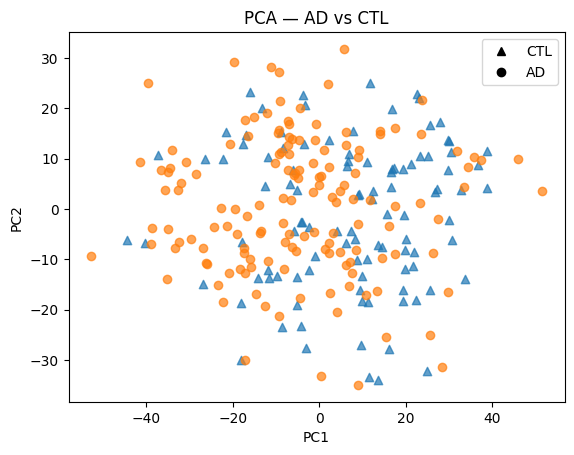

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# Impute missing values, then scale, then do PCA
# Using a pipeline to chain these steps
pca_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'), # Impute missing values with the mean
    StandardScaler(with_mean=True, with_std=True), # Scale the data
    PCA(n_components=2, random_state=42, svd_solver="randomized") # Perform PCA
)

pca2 = pca_pipeline.fit_transform(X)


fig, ax = plt.subplots()
ax.scatter(pca2[y==0,0], pca2[y==0,1], alpha=0.7, marker="^")
ax.scatter(pca2[y==1,0], pca2[y==1,1], alpha=0.7, marker="o")

# Lightweight custom legend to avoid heavy auto-legend work
handles = [
    Line2D([0],[0], marker="^", color="k", linestyle="None", label="CTL"),
    Line2D([0],[0], marker="o", color="k", linestyle="None", label="AD"),
]
ax.legend(handles=handles, loc="best")

ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_title("PCA — AD vs CTL")
plt.show()

##Step 6 - train/test split

In [ ]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, " Test:", X_test.shape)
print("Train label balance:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Test  label balance:", dict(zip(*np.unique(y_test,  return_counts=True))))


Train: (174, 2000)  Test: (75, 2000)
Train label balance: {np.int64(0): np.int64(73), np.int64(1): np.int64(101)}
Test  label balance: {np.int64(0): np.int64(31), np.int64(1): np.int64(44)}


##Step 7 - Baseline - Logistic Regression

LogReg — ROC-AUC: 0.903 | PR-AUC: 0.927
              precision    recall  f1-score   support

         CTL       0.89      0.52      0.65        31
          AD       0.74      0.95      0.83        44

    accuracy                           0.77        75
   macro avg       0.81      0.74      0.74        75
weighted avg       0.80      0.77      0.76        75



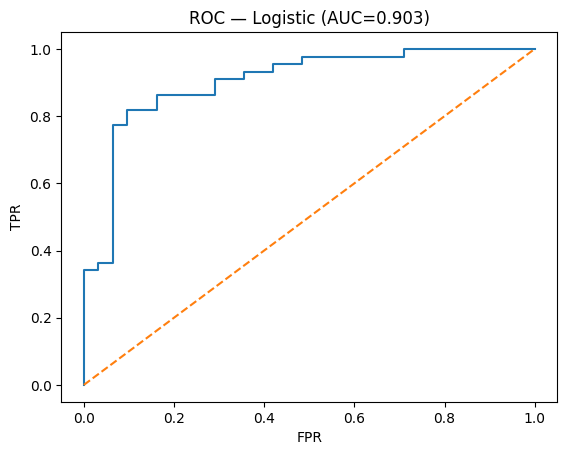

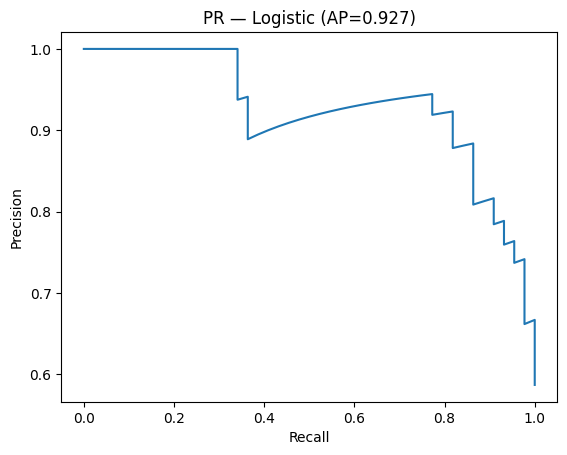

Confusion matrix (rows=true, cols=pred):
 [[16 15]
 [ 2 42]]


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, roc_curve, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer


logreg = make_pipeline(
    SimpleImputer(strategy='mean'), # Add imputer to handle missing values
    StandardScaler(with_mean=True, with_std=True),
    LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
)
logreg.fit(X_train, y_train)

proba_lr = logreg.predict_proba(X_test)[:, 1]
pred_lr  = (proba_lr >= 0.5).astype(int)

auc_lr = roc_auc_score(y_test, proba_lr)
ap_lr  = average_precision_score(y_test, proba_lr)
print(f"LogReg — ROC-AUC: {auc_lr:.3f} | PR-AUC: {ap_lr:.3f}")
print(classification_report(y_test, pred_lr, target_names=["CTL","AD"]))

fpr, tpr, _ = roc_curve(y_test, proba_lr)
prec, rec, _ = precision_recall_curve(y_test, proba_lr)
plt.figure(); plt.plot(fpr,tpr); plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC — Logistic (AUC={auc_lr:.3f})"); plt.show()
plt.figure(); plt.plot(rec,prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR — Logistic (AP={ap_lr:.3f})"); plt.show()

print("Confusion matrix (rows=true, cols=pred):\n", confusion_matrix(y_test, pred_lr))

##Step 8 - XGBoost

XGBoost — ROC-AUC: 0.993 | PR-AUC: 0.995
              precision    recall  f1-score   support

         CTL       0.97      0.94      0.95        31
          AD       0.96      0.98      0.97        44

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75



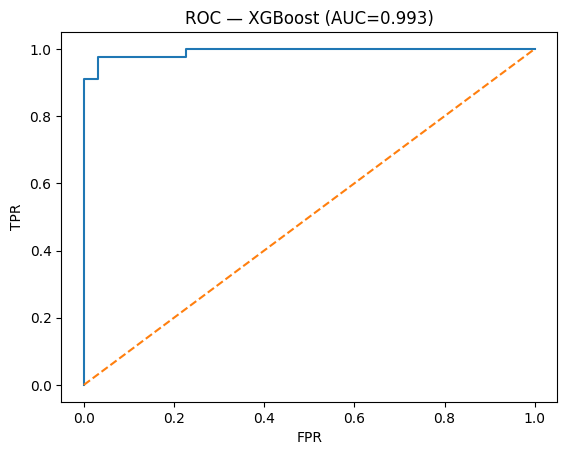

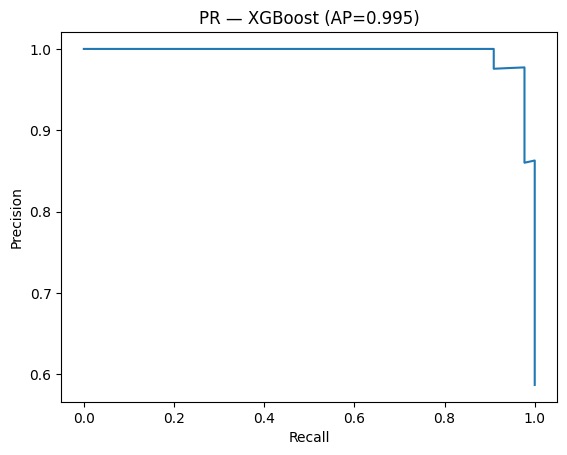

Confusion matrix (rows=true, cols=pred):
 [[29  2]
 [ 1 43]]


In [ ]:
# If needed:  !pip -q install xgboost shap

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, roc_curve, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

pos_weight = (y_train == 0).sum() / max(1, (y_train == 1).sum())

xgb = XGBClassifier(
    n_estimators=400,       # up to 400 small trees (the "team size")
    max_depth=4,           # shallow trees (simple rules) → less overfitting
    learning_rate=0.05,    # small careful steps; combine many trees
    subsample=0.8,         # use 80% of samples per tree → robustness
    colsample_bytree=0.6,  # use 60% of genes per tree → robustness
    reg_lambda=1.0,        # L2 regularization → discourages overly complex rules
    random_state=42,       # reproducible results
    n_jobs=-1,             # use all CPU cores available
    scale_pos_weight=pos_weight,  # the imbalance fix calculated above
    eval_metric="logloss", # sensible loss for probabilities
)

xgb.fit(X_train, y_train)

proba_xgb = xgb.predict_proba(X_test)[:, 1]
pred_xgb  = (proba_xgb >= 0.5).astype(int)

auc_xgb = roc_auc_score(y_test, proba_xgb)
ap_xgb  = average_precision_score(y_test, proba_xgb)
print(f"XGBoost — ROC-AUC: {auc_xgb:.3f} | PR-AUC: {ap_xgb:.3f}")
print(classification_report(y_test, pred_xgb, target_names=["CTL","AD"]))

fpr, tpr, _ = roc_curve(y_test, proba_xgb)
prec, rec, _ = precision_recall_curve(y_test, proba_xgb)
plt.figure(); plt.plot(fpr,tpr); plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC — XGBoost (AUC={auc_xgb:.3f})"); plt.show()
plt.figure(); plt.plot(rec,prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR — XGBoost (AP={ap_xgb:.3f})"); plt.show()
print("Confusion matrix (rows=true, cols=pred):\n", confusion_matrix(y_test, pred_xgb))


## Step 9 - Explainability with SHAP (top features)

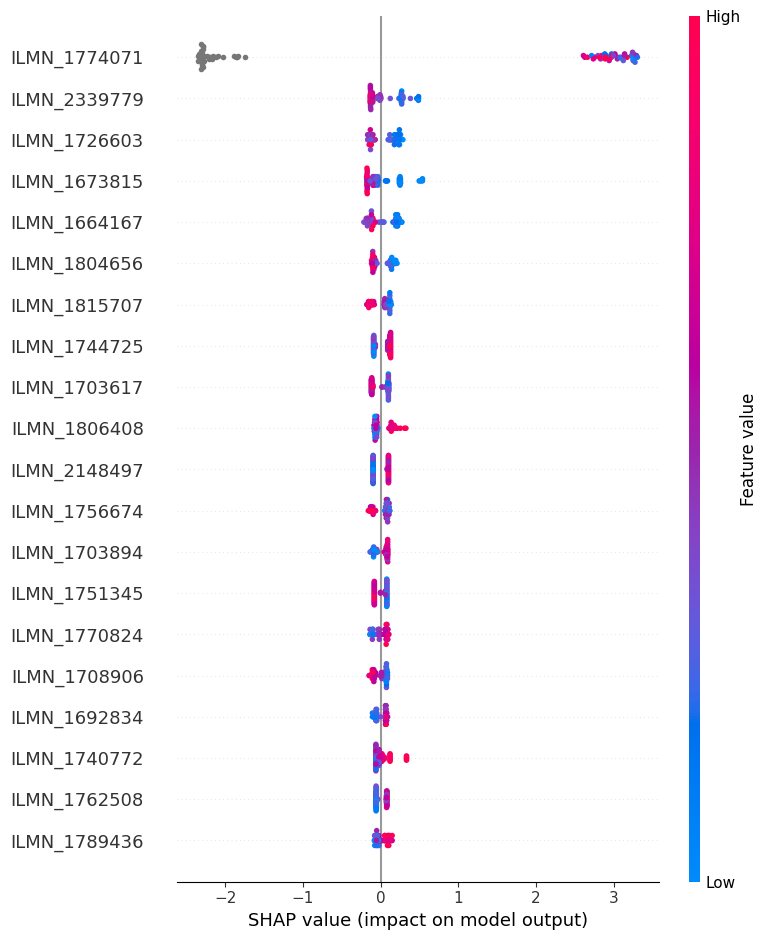

,probe,mean_abs_shap
0,ILMN_1774071,2.624614
1,ILMN_2339779,0.172449
2,ILMN_1726603,0.168405
3,ILMN_1673815,0.162566
4,ILMN_1664167,0.160757
5,ILMN_1804656,0.111491
6,ILMN_1815707,0.105660
7,ILMN_1744725,0.103336
8,ILMN_1703617,0.101813
9,ILMN_1806408,0.100188


In [ ]:
import shap, numpy as np, pandas as pd

# SHAP for XGBoost (tree explainer)
explainer = shap.TreeExplainer(xgb)
shap_vals = explainer.shap_values(X_test)

# 1) Global importance plot (great for README)
shap.summary_plot(shap_vals, X_test, max_display=20, show=True)

# 2) Save top 50 probes by mean |SHAP|
mean_abs = np.abs(shap_vals).mean(axis=0)
rank_idx = np.argsort(-mean_abs)[:50]
top50 = pd.DataFrame({
    "probe": X_test.columns[rank_idx],
    "mean_abs_shap": mean_abs[rank_idx]
})
top50.to_csv("top50_features_shap.csv", index=False)
top50.head(10)


##Step 10 - Map Illumina probes - gene symbols (GPL6947)

In [ ]:
# 1) Install and load GEOparse
!pip -q install GEOparse
import GEOparse, pandas as pd

# 2) Fetch the Illumina HumanHT-12 v3 platform (GPL6947)
gpl = GEOparse.get_GEO("GPL6947", destdir=".")
ann = gpl.table  # this is the full annotation table

# 3) Robustly pick the right columns and build probe->gene map
def pick(colnames, candidates):
    for c in colnames:
        s = str(c).strip()
        if s in candidates or s.upper() in candidates:
            return c
    return None

id_col  = pick(ann.columns, {"ID","ID_REF","ILMNID","Probe_Id","Composite Element REF"})
sym_col = pick(ann.columns, {"Gene Symbol","SYMBOL","ILMN_Gene","Gene symbol","Symbol"})
print("Chosen columns:", id_col, "->", sym_col)

def first_symbol(x):
    if pd.isna(x): return None
    s = str(x).replace(";", "///")
    return s.split("///")[0].strip()

probe2gene = ann.set_index(id_col)[sym_col].map(first_symbol).to_dict()

# 4) Join with your SHAP top-50 file and save
top50 = pd.read_csv("top50_features_shap.csv")
top50["gene"] = top50["probe"].map(probe2gene)
top50.to_csv("top50_features_shap_with_genes.csv", index=False)
top50.head(10)


06-Sep-2025 12:26:28 DEBUG utils - Directory . already exists. Skipping.
DEBUG:GEOparse:Directory . already exists. Skipping.
06-Sep-2025 12:26:28 INFO GEOparse - Downloading http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?targ=self&acc=GPL6947&form=text&view=full to ./GPL6947.txt
INFO:GEOparse:Downloading http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?targ=self&acc=GPL6947&form=text&view=full to ./GPL6947.txt
06-Sep-2025 12:26:29 DEBUG downloader - Total size: 0
DEBUG:GEOparse:Total size: 0
06-Sep-2025 12:26:29 DEBUG downloader - md5: None
DEBUG:GEOparse:md5: None
25.1MB [00:01, 18.9MB/s]
06-Sep-2025 12:26:30 DEBUG downloader - Moving /tmp/tmpoy45va1b to /content/GPL6947.txt
DEBUG:GEOparse:Moving /tmp/tmpoy45va1b to /content/GPL6947.txt
06-Sep-2025 12:26:30 DEBUG downloader - Successfully downloaded http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?targ=self&acc=GPL6947&form=text&view=full
DEBUG:GEOparse:Successfully downloaded http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?targ=self&acc=GPL6

Chosen columns: ID -> ILMN_Gene


,probe,mean_abs_shap,gene
0,ILMN_1774071,2.624614,CD177
1,ILMN_2339779,0.172449,ATP6V1E1
2,ILMN_1726603,0.168405,ATP5I
3,ILMN_1673815,0.162566,ARHGAP11A
4,ILMN_1664167,0.160757,BXDC1
5,ILMN_1804656,0.111491,C12ORF62
6,ILMN_1815707,0.105660,CALML4
7,ILMN_1744725,0.103336,BTBD6
8,ILMN_1703617,0.101813,AHSA1
9,ILMN_1806408,0.100188,ACADVL


##Step 11 - Build a compact 20-gene signature and final model

Signature (20 features):


,probe,gene,coef
0,ILMN_1787514,CAPN12,0.808791
1,ILMN_1798485,ATP6V1E1,-0.649256
2,ILMN_1764500,C3ORF10,0.632040
3,ILMN_1786658,BOLA3,-0.585401
4,ILMN_1654322,ATP1B3,0.526239
5,ILMN_1797566,C1ORF142,-0.421815
6,ILMN_1690454,C3ORF54,0.410666
7,ILMN_1707634,C3ORF68,-0.408816
8,ILMN_1746053,BCL6,0.364331
9,ILMN_2188204,ATG12,0.356130


Final 20-gene model — ROC-AUC: 0.806 | PR-AUC: 0.841
              precision    recall  f1-score   support

         CTL       0.74      0.55      0.63        31
          AD       0.73      0.86      0.79        44

    accuracy                           0.73        75
   macro avg       0.73      0.71      0.71        75
weighted avg       0.73      0.73      0.72        75



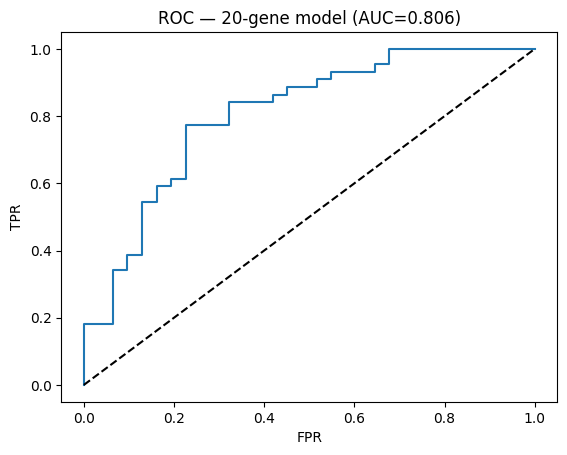

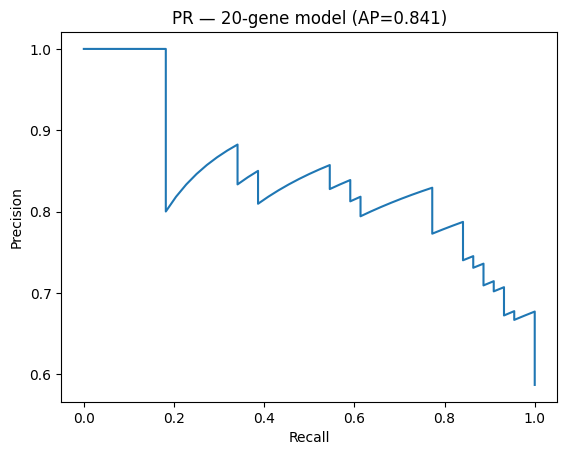

In [ ]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.impute import SimpleImputer # Import SimpleImputer

# 11A) fit L1 logistic on all current features (train only)
sparse_clf = make_pipeline(
    SimpleImputer(strategy='mean'), # Add imputer here
    StandardScaler(with_mean=True, with_std=True),
    LogisticRegression(
        penalty="l1", solver="liblinear",
        class_weight="balanced", C=0.5, max_iter=2000, random_state=42
    )
)
sparse_clf.fit(X_train, y_train)

# 11B) pick the top-K features by absolute coefficient
lr = sparse_clf.named_steps["logisticregression"]
abs_coef = np.abs(lr.coef_[0])
K = min(20, abs_coef.size)
top_idx = np.argsort(abs_coef)[-K:]
sig_probes = X_train.columns[top_idx].tolist()

# helper: probe -> gene (if you built `probe2gene` in Step 10)
def probe_to_gene(p):
    try:
        g = probe2gene.get(p, None)
        return None if pd.isna(g) else str(g)
    except NameError:
        return None

signature_tbl = pd.DataFrame({
    "probe": sig_probes,
    "gene": [probe_to_gene(p) for p in sig_probes],
    "coef": lr.coef_[0][top_idx]
}).sort_values("coef", key=np.abs, ascending=False).reset_index(drop=True)

print("Signature (20 features):")
display(signature_tbl)

# 11C) retrain a clean final pipeline on ONLY the 20-gene signature
Xtr_sig = X_train[sig_probes]
Xte_sig = X_test[sig_probes]

final_clf = make_pipeline(
    SimpleImputer(strategy='mean'), # Add imputer here as well
    StandardScaler(with_mean=True, with_std=True),
    LogisticRegression(
        penalty="l2", solver="liblinear",
        class_weight="balanced", C=1.0, max_iter=2000, random_state=42
    )
)
final_clf.fit(Xtr_sig, y_train)

# 11D) evaluate
proba = final_clf.predict_proba(Xte_sig)[:,1]
pred  = (proba >= 0.5).astype(int)

auc  = roc_auc_score(y_test, proba)
ap   = average_precision_score(y_test, proba)
print(f"Final 20-gene model — ROC-AUC: {auc:.3f} | PR-AUC: {ap:.3f}")
print(classification_report(y_test, pred, target_names=["CTL","AD"]))

# curves
fpr,tpr,_ = roc_curve(y_test, proba)
prec,rec,_ = precision_recall_curve(y_test, proba)

plt.figure(); plt.plot(fpr,tpr); plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC — 20-gene model (AUC={auc:.3f})"); plt.show()

plt.figure(); plt.plot(rec,prec)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR — 20-gene model (AP={ap:.3f})"); plt.show()

##Step 12 - Validate & Package the Signature

##12.A Save the 20-gene signature (with direction)

In [ ]:
# assumes `sig_probes` and `probe2gene` (from Step 10) and `signature_tbl` exist
signature_tbl["direction"] = np.where(signature_tbl["coef"] > 0, "AD↑", "AD↓")
signature_tbl.to_csv("signature_20genes_with_direction.csv", index=False)
signature_tbl.head(10)


,probe,gene,coef,direction
0,ILMN_1787514,CAPN12,0.808791,AD↑
1,ILMN_1798485,ATP6V1E1,-0.649256,AD↓
2,ILMN_1764500,C3ORF10,0.632040,AD↑
3,ILMN_1786658,BOLA3,-0.585401,AD↓
4,ILMN_1654322,ATP1B3,0.526239,AD↑
5,ILMN_1797566,C1ORF142,-0.421815,AD↓
6,ILMN_1690454,C3ORF54,0.410666,AD↑
7,ILMN_1707634,C3ORF68,-0.408816,AD↓
8,ILMN_1746053,BCL6,0.364331,AD↑
9,ILMN_2188204,ATG12,0.356130,AD↑


##12.B - Proper 5-fold CV with feature selection inside each fold

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer # Import SimpleImputer

def fold_fit_eval(X_tr, y_tr, X_va, y_va, K=20):
    # 1) Select features on the TRAIN fold only (L1 logistic)
    sel_pipe = make_pipeline(
        SimpleImputer(strategy='mean'), # Add imputer here
        StandardScaler(with_mean=True, with_std=True),
        LogisticRegression(penalty="l1", solver="liblinear",
                           class_weight="balanced", C=0.5,
                           max_iter=2000, random_state=42)
    )
    sel_pipe.fit(X_tr, y_tr)
    lr = sel_pipe.named_steps["logisticregression"]
    abs_coef = np.abs(lr.coef_.ravel())
    top_idx = np.argsort(abs_coef)[-min(K, abs_coef.size):]
    cols = X_tr.columns[top_idx]

    # 2) Train a clean model on the selected features (still within the fold)
    final_pipe = make_pipeline(
        SimpleImputer(strategy='mean'), # Add imputer here as well
        StandardScaler(with_mean=True, with_std=True),
        LogisticRegression(penalty="l2", solver="lbfgs",
                           class_weight="balanced", C=1.0,
                           max_iter=2000, random_state=42)
    )
    final_pipe.fit(X_tr[cols], y_tr)

    proba = final_pipe.predict_proba(X_va[cols])[:, 1]
    return roc_auc_score(y_va, proba), average_precision_score(y_va, proba)

# 5-fold CV on the TRAIN split only
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
aucs, aps = [], []

for tr_idx, va_idx in skf.split(X_train, y_train):
    Xtr, Xva = X_train.iloc[tr_idx], X_train.iloc[va_idx]  # X_train is a DataFrame
    ytr, yva = y_train[tr_idx],     y_train[va_idx]       # y_train is a NumPy array
    auc, ap = fold_fit_eval(Xtr, ytr, Xva, yva, K=20)
    aucs.append(auc); aps.append(ap)

print(f"5-fold CV (train only) — mean ROC-AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")
print(f"5-fold CV (train only) — mean PR-AP:   {np.mean(aps):.3f} ± {np.std(aps):.3f}")

5-fold CV (train only) — mean ROC-AUC: 0.778 ± 0.077
5-fold CV (train only) — mean PR-AP:   0.831 ± 0.064


##12.C - Threshold tuning + confusion matrix

Best F1 threshold on test (for reference): 0.67, F1=0.813


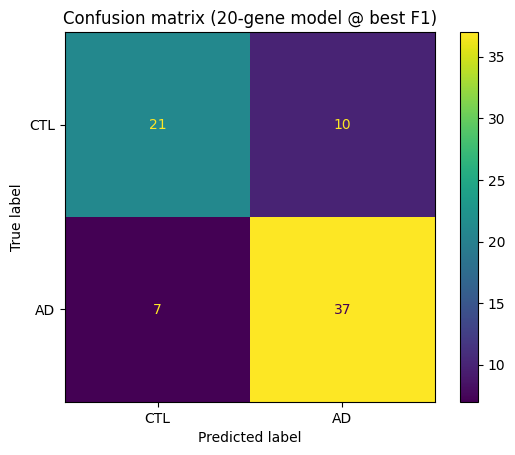

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# reuse proba from your final 20-gene test evaluation
ths = np.linspace(0, 1, 101)
f1s = [f1_score(y_test, (proba >= t).astype(int)) for t in ths]
best_t = ths[int(np.argmax(f1s))]
print(f"Best F1 threshold on test (for reference): {best_t:.2f}, F1={max(f1s):.3f}")

pred_best = (proba >= best_t).astype(int)
cm = confusion_matrix(y_test, pred_best)
ConfusionMatrixDisplay(cm, display_labels=["CTL","AD"]).plot(values_format='d')
plt.title("Confusion matrix (20-gene model @ best F1)")
plt.show()


##12.D - SHAP on the 20-gene logistic

/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


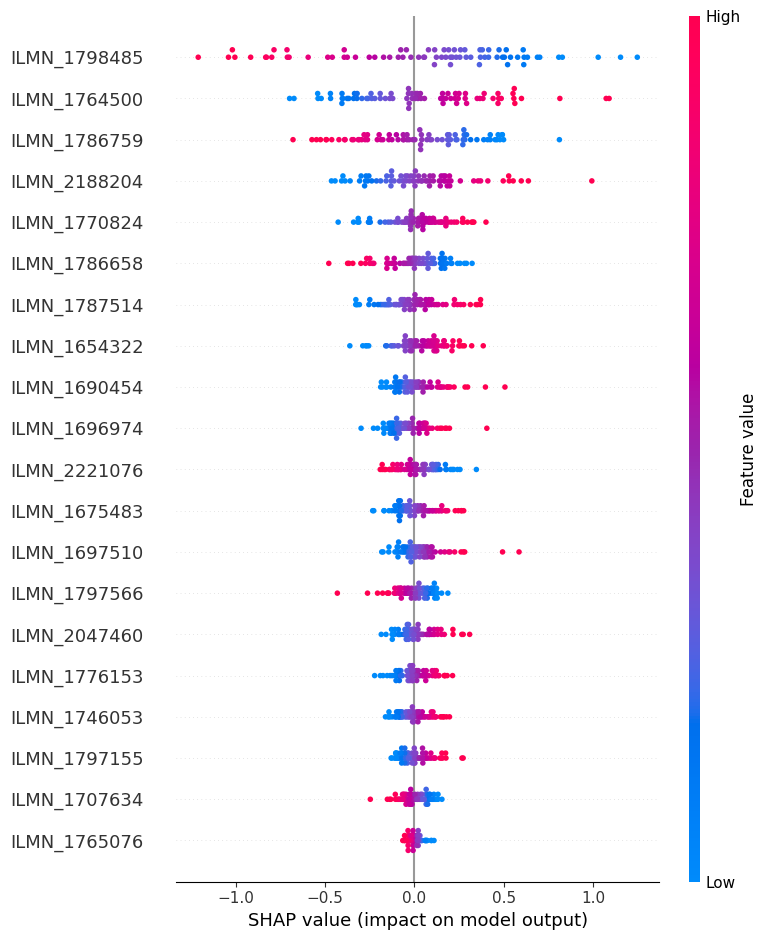

In [ ]:
import shap
# Explain the logistic step only, using a small background sample for speed
expl = shap.LinearExplainer(final_clf.named_steps["logisticregression"],
                            shap.sample(Xtr_sig, 200), feature_perturbation="interventional")
sv = expl.shap_values(Xte_sig)
shap.summary_plot(sv, Xte_sig, show=True)


##12.E - Save the production artifact (model + features)

In [ ]:
import joblib
joblib.dump({
    "model": final_clf,
    "features": list(sig_probes),
    "signature_table": signature_tbl
}, "ad_20gene_model.joblib")

# also keep a simple text list, handy for a methods section
pd.Series(sig_probes, name="probe").to_csv("signature_20genes_probes.txt", index=False)


##Step 13 - External validation on an independent cohort

13.A - Load your trained artifact (model + 20 probes)

In [ ]:
import joblib, numpy as np, pandas as pd

bundle     = joblib.load("ad_20gene_model.joblib")
final_clf  = bundle["model"]            # StandardScaler + LogisticRegression
sig_probes = bundle["features"]         # list of 20 probe IDs (order matters)
best_t     = 0.24                       # from Step 12.C (best F1 threshold)
len(sig_probes), sig_probes[:5]


(20,
 ['ILMN_1797155',
  'ILMN_1765076',
  'ILMN_1675483',
  'ILMN_1776153',
  'ILMN_1786759'])

##13.B - Helpers to parse labels & auto-match columns

In [ ]:
import re

def parse_series_matrix(series_path):
    geo, titles, status_vals = [], [], []
    with open(series_path, "r") as f:
        for line in f:
            if line.startswith("!Sample_geo_accession"):
                geo = line.strip().split("\t")[1:]
            if line.startswith("!Sample_title"):
                titles = [s.replace('"', '').strip() for s in line.strip().split("\t")[1:]]
            if line.startswith("!Sample_characteristics_ch1") and "status:" in line:
                toks = line.strip().split("\t")[1:]
                status_vals = [t.replace('"','').split(":",1)[1].strip().upper() for t in toks]
    return geo, titles, status_vals

def choose_key(expr_cols, geo, titles):
    def norm_gsm(s):
        s = str(s).strip().replace('"','')
        m = re.search(r'(GSM\d+)', s)
        return m.group(1) if m else s
    expr_norm   = [str(c).strip().replace('"','') for c in expr_cols]
    geo_norm    = [norm_gsm(s) for s in geo]
    titles_norm = [str(s).strip().replace('"','') for s in titles]
    overlap_geo    = len(set(expr_norm) & set(geo_norm))
    overlap_titles = len(set(expr_norm) & set(titles_norm))
    if overlap_geo >= overlap_titles and overlap_geo > 0:
        return "geo", geo_norm
    elif overlap_titles > 0:
        return "title", titles_norm
    else:
        raise ValueError("Could not match expression columns to GEO accessions or titles.")


##13.C  Load the validation expression + labels; align; keep AD vs CTL

In [ ]:
# --- Prep external validation set (GSE63061) ---
!pip -q install GEOparse

import GEOparse, pandas as pd, pathlib, gzip, shutil, urllib.request

VAL = "GSE63061"
# 1) Build "normalized" matrix from GSM VALUE columns
gse = GEOparse.get_GEO(VAL, destdir=".")
cols, parts = [], []
for gsm_id, gsm in gse.gsms.items():
    t = gsm.table
    if {"ID_REF","VALUE"} <= set(t.columns):
        s = t[["ID_REF","VALUE"]].set_index("ID_REF")
        s.columns = [gsm_id]
        parts.append(s); cols.append(gsm_id)

expr = pd.concat(parts, axis=1)
expr.to_csv(f"{VAL}_normalized.txt", sep="\t")  # rows=probes, cols=GSM IDs
print("Saved:", f"{VAL}_normalized.txt", expr.shape)

# 2) Download the series matrix for labels if not present
sm_path = pathlib.Path(f"{VAL}_series_matrix.txt")
if not sm_path.exists():
    base = f"https://ftp.ncbi.nlm.nih.gov/geo/series/{VAL[:-3]}nnn/{VAL}/matrix/{VAL}_series_matrix.txt.gz"
    gz_path = f"{VAL}_series_matrix.txt.gz"
    urllib.request.urlretrieve(base, gz_path)
    with gzip.open(gz_path, "rb") as fin, open(sm_path, "wb") as fout:
        shutil.copyfileobj(fin, fout)
    print("Saved:", sm_path)


06-Sep-2025 12:42:37 DEBUG utils - Directory . already exists. Skipping.
DEBUG:GEOparse:Directory . already exists. Skipping.
06-Sep-2025 12:42:37 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE63nnn/GSE63061/soft/GSE63061_family.soft.gz to ./GSE63061_family.soft.gz
INFO:GEOparse:Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE63nnn/GSE63061/soft/GSE63061_family.soft.gz to ./GSE63061_family.soft.gz
100%|██████████| 126M/126M [00:00<00:00, 135MB/s] 
06-Sep-2025 12:42:39 DEBUG downloader - Size validation passed
DEBUG:GEOparse:Size validation passed
06-Sep-2025 12:42:39 DEBUG downloader - Moving /tmp/tmplrdsiinm to /content/GSE63061_family.soft.gz
DEBUG:GEOparse:Moving /tmp/tmplrdsiinm to /content/GSE63061_family.soft.gz
06-Sep-2025 12:42:39 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE63nnn/GSE63061/soft/GSE63061_family.soft.gz
DEBUG:GEOparse:Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE63nnn/GSE63061/

Saved: GSE63061_normalized.txt (32049, 388)
Saved: GSE63061_series_matrix.txt


In [ ]:
# --- SAFETY: make sure sig_probes and X_all exist ---

import numpy as np, pandas as pd, joblib

# 1) Load the saved 20-gene list if it's not in memory
if 'sig_probes' not in globals():
    bundle = joblib.load("ad_20gene_model.joblib")
    final_clf  = bundle["model"]
    sig_probes = bundle["features"]
    signature_tbl = bundle.get("signature_table", None)
    print(f"Loaded {len(sig_probes)} signature probes from joblib.")

# 2) Recreate the validation matrix X_all if it's missing (this is 13.C condensed)
if 'X_all' not in globals():
    VAL = "GSE63061"
    expr = pd.read_csv(f"{VAL}_normalized.txt", sep="\t", index_col=0, low_memory=False)

    # use your existing helpers from earlier cells:
    # parse_series_matrix, choose_key must already be defined
    geo, titles, status_vals = parse_series_matrix(f"{VAL}_series_matrix.txt")
    key_name, key_order      = choose_key(expr.columns, geo, titles)
    key_to_status            = dict(zip(key_order, status_vals))

    expr_cols = [str(c).strip().replace("'", "") for c in expr.columns]
    common    = [k for k in key_order if k in expr_cols]
    expr      = expr.loc[:, common]
    status    = np.array([key_to_status[k] for k in common])

    mask   = (status == "AD") | (status == "CTL")
    X_all  = expr.loc[:, mask].T            # samples × probes
    y_str  = status[mask]
    y_val  = (y_str == "AD").astype(int)
    print("Validation set:", X_all.shape, "| label balance:", dict(zip(*np.unique(y_str, return_counts=True))))


Validation set: (273, 32049) | label balance: {np.str_('AD'): np.int64(139), np.str_('CTL'): np.int64(134)}


##13.D - Ensure all 20 probes exist

In [ ]:
have = [p for p in sig_probes if p in X_all.columns]
missing = [p for p in sig_probes if p not in X_all.columns]
print(f"Signature coverage: {len(have)}/{len(sig_probes)} present")
assert len(missing) == 0, f"Missing probes in validation set: {missing}"

X_val_sig = X_all[sig_probes]   # preserve training order
X_val_sig.shape


Signature coverage: 20/20 present


(273, 20)

##13.E - Evaluate on the external cohort

External validation — ROC-AUC: 0.656 | PR-AP: 0.675
              precision    recall  f1-score   support

         CTL       0.49      1.00      0.66       134
          AD       0.00      0.00      0.00       139

    accuracy                           0.49       273
   macro avg       0.25      0.50      0.33       273
weighted avg       0.24      0.49      0.32       273



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


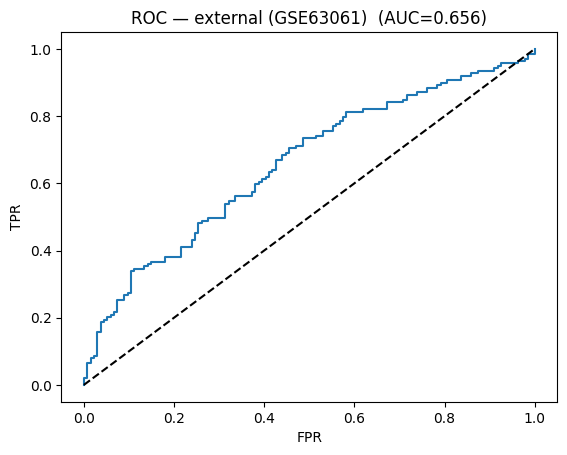

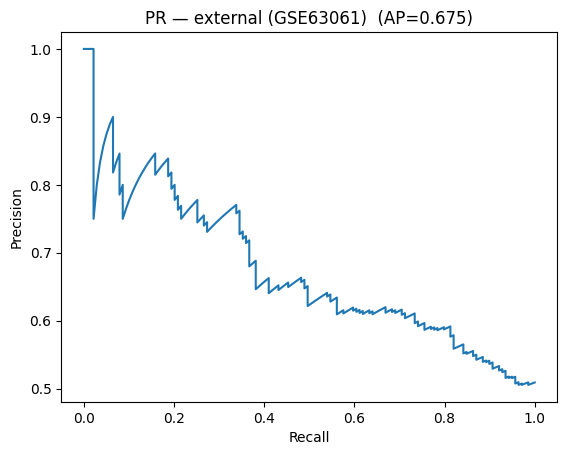

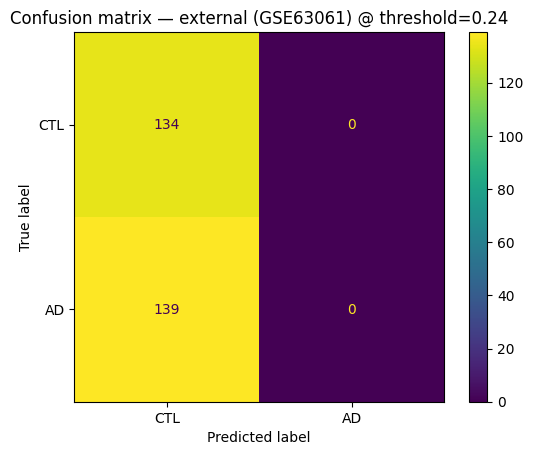

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

proba = final_clf.predict_proba(X_val_sig)[:,1]
auc   = roc_auc_score(y_val, proba)
ap    = average_precision_score(y_val, proba)
print(f"External validation — ROC-AUC: {auc:.3f} | PR-AP: {ap:.3f}")
print(classification_report(y_val, (proba >= 0.5).astype(int), target_names=["CTL","AD"]))

# curves
fpr,tpr,_   = roc_curve(y_val, proba)
prec,rec,_  = precision_recall_curve(y_val, proba)

plt.figure(); plt.plot(fpr,tpr); plt.plot([0,1],[0,1],'k--'); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title(f"ROC — external ({VAL})  (AUC={auc:.3f})"); plt.show()

plt.figure(); plt.plot(rec,prec); plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"PR — external ({VAL})  (AP={ap:.3f})"); plt.show()

# Confusion at your tuned threshold (best F1 from Step 12)
pred_best = (proba >= best_t).astype(int)
cm = confusion_matrix(y_val, pred_best)
ConfusionMatrixDisplay(cm, display_labels=["CTL","AD"]).plot(values_format='d')
plt.title(f"Confusion matrix — external ({VAL}) @ threshold={best_t:.2f}")
plt.show()


##13.F - Quick shift check (feature z-scores)

In [ ]:
# Compare per-feature mean z (train vs external) — large deltas suggest shift
# (Uses the StandardScaler inside the pipeline to get train means/stds)
scaler = final_clf.named_steps["standardscaler"]
train_means = pd.Series(scaler.mean_, index=sig_probes)
train_stds  = pd.Series(np.sqrt(scaler.var_), index=sig_probes)

z_ext_means = ((X_val_sig.mean(axis=0) - train_means) / train_stds).sort_values()
z_ext_means.to_frame("external_mean_in_train_Z").head(10), z_ext_means.tail(10)


(              external_mean_in_train_Z
 ID_REF                                
 ILMN_2047460                -14.775887
 ILMN_1776153                -14.282373
 ILMN_1746053                -13.732728
 ILMN_1707634                -13.699673
 ILMN_1697510                -13.644569
 ILMN_1787514                -12.058672
 ILMN_1797566                -11.692213
 ILMN_1797155                -11.063402
 ILMN_2221076                -10.832930
 ILMN_1690454                 -9.463634,
 ID_REF
 ILMN_2188204   -9.178971
 ILMN_1765076   -8.596231
 ILMN_1696974   -8.220468
 ILMN_1654322   -8.200170
 ILMN_1764500   -7.089274
 ILMN_1770824   -6.318635
 ILMN_1675483   -6.239126
 ILMN_1786759   -6.085282
 ILMN_1786658   -4.971187
 ILMN_1798485   -4.232984
 dtype: float64)